# Week5 Basic

- 해야할 과제

    1) https://spartacodingclub.kr/blog/all-in-challenge_winner 에서 수상작 요약하기

    2) chroma를 통해 query와 유사한 문서를 검색하여 llm에게 요약을 요청하기

- 더 해 볼 과제
    - 참조: https://huggingface.co/learn/cookbook/ko/advanced_ko_rag#%EC%9E%85%EB%A0%A5input

    1) query와 문서 정보 임베딩 시각화

    2) 로컬 모델로 임베딩과 문장 생성을 해보기.




## 1 [My Code] Data Preparation

### 1.1 [My Code] API Key Load

In [1]:
import os
import openai
from dotenv import load_dotenv

load_dotenv(dotenv_path="config.env")
openai.api_key = os.getenv("OPENAI_API_KEY")

### 1.2 [My Code] Model Load

- streaming = True

- callbacks = StreamingStdOutCallbackHandler

위의 두 가지 옵션을 주면, 문장이 최종 생성되는 과정을 시각화 해줍니다.

In [2]:
from langchain.callbacks import StreamingStdOutCallbackHandler
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.7,
    max_tokens=1024,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
    )

### 1.3 [My Code] Data Load and preprocessing

- webbaseloader -> UnstructuredURLLoader 변경

- recursive splitter가 반복되는 데이터를 생산하는 것을 list -> set -> list 방식으로 중복 제거.

- 전체 문서 10가지 생성


    - 문서 수가 많지는 않지만 rag를 직접 구현해보는 것에 의의를 둔기로 합니다.

    - 전체 수상작은 6개 입니다. 추후에 몇 개나 요약되는지 확인해보도록 합니다.

In [3]:
from langchain_community.document_loaders import UnstructuredURLLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import Document

# url을 unstructuredURLLoader를 사용해 불러옵니다.
# 해당 툴을 사용하면, 별다른 설정없이 url의 정보를 가져옵니다.
url = "https://spartacodingclub.kr/blog/all-in-challenge_winner"
loader = UnstructuredURLLoader(urls=[url])
docs = loader.load()

# 텍스트 분할기 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=900,  # 각 청크의 최대 길이
    chunk_overlap=300  # 청크 간 겹침 부분 최소화
)

# 문서 분할
# recursive는 동일한 문서를 출력하는 경우가 있어, 아래처럼 list -> set -> list로 중복을 제거합니다.
split_docs = text_splitter.split_documents(docs)
splits = list(set([doc.page_content for doc in split_docs]))
splits = [
    Document(
        metadata={'idx': i},
        page_content=text_data
    )
        for i, text_data in enumerate(splits)
]

for i, doc in enumerate(splits):
    print(f"{i+1}번째")
    print(len(doc.page_content))
    print(doc.page_content)
    print("###\n")

1번째
862
사용한 기술 스택

FE(프론트엔드): React, Tesseract.js, React-Quill, HTML, CSS, JavaScript

BE(백엔드): Java, Spring Boot, MariaDB

🎖️ 우수상

[우리집 히어로즈] 벌레 퇴치 영웅 매칭 서비스

서비스 제작자: 인트(배정연, 한지수)

💡C는 이번 학기 처음으로 자취를 시작했습니다. 원래부터 작은 벌레에 민감했던 C. 자취방에서 자주 나타나는 벌레들 때문에 밤잠을 설치길 반복했습니다. 밤마다 벌레를 잡으려고 애쓰던 C는 커뮤니티를 통해 다른 학생들도 같은 문제를 겪고 있다는 것을 알게 되었습니다. 하지만 커뮤니티에서 벌레 퇴치 히어로를 찾기 위해서는 내 개인 정보를 노출해야 한다는 점이 찝찝했죠.

이 문제를 해결할 수 있는 방법이 바로 <우리집 히어로즈> 서비스입니다. 대학생 자취생들이 자취방에서 겪는 벌레 문제를 해결하기 위해 개발된 앱이죠. 벌레 퇴치가 필요한 사용자가 앱에 요청을 올리면 벌레 퇴치 히어로 학우와 매칭됩니다. 사용자 신원은 같은 학교 학생으로, 신원이 보장된 안전한 환경에서 이뤄지고 벌레를 퇴치해주는 히어로는 추가 수입을 얻을 수 있는 기회를 가집니다. 실시간 알림 기능을 통해 매칭이 이뤄지면 즉시 알림을 받을 수 있어 빠르게 문제를 해결할 수 있습니다. 벌레를 퇴치한 후 사용자는 서로를 평가할 수 있어요. 더 나은 서비스를 제공하거나 받을 수 있습니다.

사용한 기술 스택

FE(프론트엔드): React Native, Expo, Axios

BE(백엔드): Spring Boot, Spring Security, MySQL, SSE, FCM, JWT, Postman

🎖️ 우수상

[에코 클래스룸] 수업 실시간 소통 서비스
###

2번째
814
사용한 기술 스택

FE(프론트엔드): Flutter, Socket.IO, Expo CLI, Axios, TanStack Query

BE(백엔드): Spring Boot, Spring Security, JW

## 2 [My Code] Text Retrieval

### 2.1 [My Code] Chroma Database 

- 코사인 유사도 방식으로 전체 문서에서 40%만 추출합니다.

In [4]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# OpenAI Embeddings 초기화
# https://platform.openai.com/docs/guides/embeddings
embeddings = OpenAIEmbeddings(
    api_key=openai.api_key,
    model="text-embedding-3-small"
)

# Chroma 벡터 저장소 생성 및 로컬 저장 경로 지정
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    collection_name="my_db"
)

# 전체 문서의 40%를 출력합니다.
chroma_retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': int(len(splits) * 0.4)}
)

user_msg = "ALL-in 코딩 공모전 수상작들을 요약해줘."
retrieved_docs = chroma_retriever.invoke(user_msg)
retrieved_docs

[Document(id='76418ee9-4b1e-4e10-b88a-2dce4a541ab9', metadata={'idx': 2}, page_content="로그인\n\n로그아웃\n\n스파르타 소식\n\n'AII-in 코딩 공모전’ 수상작을 소개합니다\n\n조회수 458·6분 분량\n\n2024. 9. 3.\n\n코딩은 더 이상 개발자만의 영역이 아닙니다. 누구나 아이디어만 있다면 창의적인 서비스를 만들어 세상을 바꿀 수 있습니다. 스파르타코딩클럽에서는 이러한 가능성을 믿고, 누구나 코딩을 통해 자신의 아이디어를 실현하고 실제 문제를 해결하는 경험을 쌓을 수 있도록 다양한 프로그램을 마련하고 있습니다.\n\n<All-in> 코딩 공모전은 대학생들이 캠퍼스에서 겪은 불편함과 문제를 자신만의 아이디어로 해결해보는 대회였는데요. 이번 공모전에서 다양한 혁신적인 아이디어와 열정으로 가득한 수많은 프로젝트가 탄생했습니다. 그중 뛰어난 성과를 낸 수상작 6개를 소개합니다.\n\n🏆 대상\n\n[Lexi Note] 언어공부 필기 웹 서비스\n\n서비스 제작자: 다나와(김다애, 박나경)\n\n💡W는 어문학을 전공하는 대학생입니다. 매일 새로운 단어와 문장 구조를 공부하고 있지만, 효율적으로 학습하는 것이 쉽지 않았습니다. 단어의 의미를 찾기 위해 사전을 뒤적이고, 긴 문장을 이해하려고 번역기를 사용하다 보면, 필기 노트는 어느새 뒷전으로 밀려났거든요. 사전, 번역기, 원서, 필기노트를 왔다 갔다 하다 보면 시간이 다 지나가 버리곤 했죠."),
 Document(id='8ee8bb01-6de4-4ceb-9324-b01cc6f2a045', metadata={'idx': 9}, page_content='💡<All-in> 코딩 공모전에서 만든 다양한 서비스를 만나보고 싶다면?\n\n다양한 서비스와 기발한 아이디어가 모인 곳에 초대합니다. 참가자들의 문제 해결방법이 궁금하시다면 지금 바로 ‘All-in 공모전’에서 만나보세요!\n\n👉🏻 공모전 결과물 보러가기\n\n누구나 큰일 낼 

### 2.2 [My Code] 임베딩 정보

- openai 모델 중 text-embedding-3-small로 임베딩을 하였습니다.

- 차원 수는 1536입니다.

In [5]:
# https://stackoverflow.com/questions/76482987/chroma-database-embeddings-none-when-using-get
# embedding 정보를 보기 위해선 아래처럼 include 에 인자로 embeddings를 넣어줘야 합니다.
# 벡터 개수 확인
vector_count = vectorstore._collection.count()

# query의 임베딩 결과를 표시합니다
query_vector = embeddings.embed_query(user_msg)

print("사용하는 임베딩 모델:", embeddings.model)
print("(문서 수, 차원) = ", vectorstore.get(include=['embeddings'])['embeddings'].shape)
print("임베딩 표현 : ", vectorstore.get(include=['embeddings'])['embeddings'][0])
print(f"쿼리 임베딩 결과: {len(query_vector)} 차원")

사용하는 임베딩 모델: text-embedding-3-small
(문서 수, 차원) =  (10, 1536)
임베딩 표현 :  [-0.04162731  0.01610233  0.00085401 ... -0.0278108   0.00438433
 -0.0010056 ]
쿼리 임베딩 결과: 1536 차원


### 2.3 [My Code] 벡터 임베딩 시각화

- 아래는 문서와 query를 임베딩한 것을 umap을 통해 시각화해보는 과정입니다.

- umap은 비선형적 차원 축소 방법입니다.

- umap을 기반으로 query 근방의 doc과 retrieve 된 docs가 얼마나 일치하는지 확인해볼 것입니다.

- [Feedback] 코사인 유사도 기반으로 추출된 문서와 시각화 되어 query와 가까운 문서가 약간 다른 이유는 무엇일까요?

/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


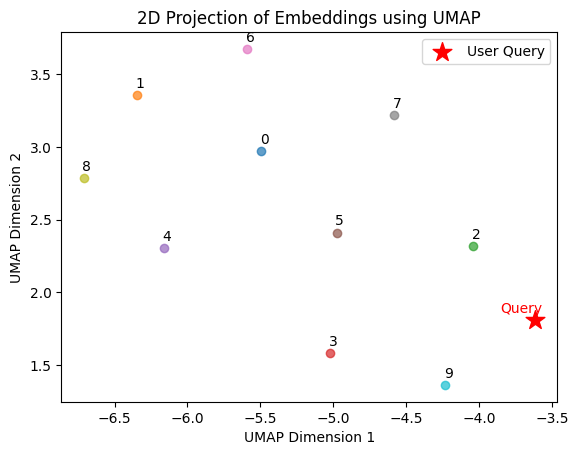

In [6]:
# 벡터 스토어와 query의 임베딩 결과를 시각화할 예정입니다. 
# query에서 근접한 점들과 retrieval을 통해 추출된 문서가 어느정도 일치하는지 확인해보겠습니다. 
import umap
import numpy as np
import matplotlib.pyplot as plt

# 모든 문서의 벡터 가져오기
doc_embeddings = vectorstore._collection.get(include=['embeddings'])["embeddings"]
embeddings_2d = np.concatenate([doc_embeddings, np.array(query_vector).reshape(1,-1)], axis=0)

# UMAP으로 2D 변환
# PCA는 선형적 방법으로 차원을 축소한다면, umap은 비선형적 방법으로 차원을 축소합니다. 
reducer = umap.UMAP(n_components=2, random_state=42)
documents_projected = reducer.fit_transform(embeddings_2d)

# 문서별로 점과 텍스트 추가
for i, doc in enumerate(splits):
    x, y = documents_projected[i]
    plt.scatter(x, y, alpha=0.7)
    plt.text(x+0.05, y+0.05, f"{i}", fontsize=10, ha='right') 

# 사용자 쿼리 표시
query_x, query_y = documents_projected[-1]
plt.scatter(query_x, query_y, color="red", label="User Query", marker="*", s=200)
plt.text(query_x+0.05, query_y+0.05, "Query", fontsize=10, color="red", ha='right')  

# 그래프 설정
plt.title("2D Projection of Embeddings using UMAP")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(loc="best")
plt.show()


## 3 [My Code] Conclusion

- 6가지 입선작 중에서 2가지만 나온 것으로 확인이 됩니다.

- 전체 문서량 자체가 작은데, 거기에서 일부를 추출하는 과정에서 정보가 많이 탈락한 것으로 결론을 내릴 수 있습니다. 

- 최근 만능 rag론이 대두되고 있는데, 문서를 어떻게 전처리 할 것인지, 그리고 어떻게 잘 검색할 것인지를 다듬지 않고선 무딘 칼과 같다고 할 수 있습니다. 

In [7]:
from langchain import hub

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

prompt = hub.pull("rlm/rag-prompt")
user_prompt = prompt.invoke({"context": format_docs(retrieved_docs), "question": user_msg})
response = llm.invoke(user_prompt)

/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


'All-in' 코딩 공모전의 수상작들은 대학생들이 캠퍼스에서 겪는 문제를 해결하기 위해 창의적인 아이디어를 바탕으로 개발한 웹 및 앱 서비스입니다. 대상은 언어 공부를 효율적으로 도와주는 'Lexi Note'이며, 우수상에는 벌레 퇴치 영웅을 매칭하는 '우리집 히어로즈'가 선정되었습니다. 이 공모전은 참가자들이 자신의 아이디어를 실현할 수 있는 기회를 제공합니다.

In [8]:
print(response)

content="'All-in' 코딩 공모전의 수상작들은 대학생들이 캠퍼스에서 겪는 문제를 해결하기 위해 창의적인 아이디어를 바탕으로 개발한 웹 및 앱 서비스입니다. 대상은 언어 공부를 효율적으로 도와주는 'Lexi Note'이며, 우수상에는 벌레 퇴치 영웅을 매칭하는 '우리집 히어로즈'가 선정되었습니다. 이 공모전은 참가자들이 자신의 아이디어를 실현할 수 있는 기회를 제공합니다." additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63'} id='run-1a45201b-ff8f-404b-9f84-b03b7b3960cc-0'


## 4 [My Code] 로컬 모델로 langchain 구현해보기

- 아래의 모델을 활용하여 로컬 모델로 rag를 구현해볼 것입니다.

    - 임베딩 모델: snunlp/KR-SBERT-V40K-klueNLI-augSTS

    - 문장 생성 모델: Bllossom/llama-3.2-Korean-Bllossom-3B

- 해당 과제를 수행함으로써, 보안에 민감한 데이터가 클라우드를 타지 않도록 환경을 구현해볼 수 있습니다.


### 4.1 [My Code] Data Preparation

- Data를 준비합니다. 이는 위에서 한 과정과 동일합니다.

In [9]:
# url을 unstructuredURLLoader를 사용해 불러옵니다.
# 해당 툴을 사용하면, 별다른 설정없이 url의 정보를 가져옵니다.
url = "https://spartacodingclub.kr/blog/all-in-challenge_winner"
loader = UnstructuredURLLoader(urls=[url])
docs = loader.load()

# 텍스트 분할기 설정
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=900,  # 각 청크의 최대 길이
    chunk_overlap=300  # 청크 간 겹침 부분 최소화
)

# 문서 분할
# recursive는 동일한 문서를 출력하는 경우가 있어, 아래처럼 list -> set -> list로 중복을 제거합니다.
split_docs = text_splitter.split_documents(docs)
splits = list(set([doc.page_content for doc in split_docs]))
splits = [
    Document(
        metadata={'idx': i},
        page_content=text_data
    )
        for i, text_data in enumerate(splits)
]


### 4.2 [My Code] Embedding 모델 선언과 vectorstore준비비

- 임베딩 모델을 로컬 모델로 사용하기 위해선 아래의 사항을 준비해야 합니다.

- 임베딩 모델을 사용할 때엔 반드시 인코더 베이스 모델을 사용토록 합니다.

- 임베딩 모델이 달라지니 openai api를 사용해서 추출한 유사 모델과 달라지는 것을 확인할 수 있습니다. 해당 모델은 한국어 finetuning이 된 모델이기에 충분히 차이가 날 수 있습니다. 여기서 알 수 있듯, 문서 유사도를 계산하는 것도 embedding을 통해 계산하는 것이기 때문에 어떤 embedding 모델을 사용할 것인지 결정하는 것 또한 큰 영향을 줍니다.

- 참고: https://huggingface.co/learn/cookbook/ko/advanced_ko_rag#%EC%9E%85%EB%A0%A5input

In [10]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

# 로컬 환경에서 사용할 임베딩 모델입니다.
embedding_model_name = "snunlp/KR-SBERT-V40K-klueNLI-augSTS"
embedding_model = HuggingFaceEmbeddings(
    model_name=embedding_model_name,
    encode_kwargs={"normalize_embeddings": True},
)

# Chroma 벡터 저장소 생성 및 로컬 저장 경로 지정
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=embedding_model,
    collection_name="my_db_local_embeddings"
)

# 전체 문서의 40%를 출력합니다.
chroma_retriever = vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': int(len(splits) * 0.4)}
)

user_msg = "ALL-in 코딩 공모전 수상작들을 요약해줘."
retrieved_docs = chroma_retriever.invoke(user_msg)
retrieved_docs

/tmp/ipykernel_85935/2499830569.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


[Document(id='e57360ae-1605-42d8-8496-f942e7199b2a', metadata={'idx': 2}, page_content="로그인\n\n로그아웃\n\n스파르타 소식\n\n'AII-in 코딩 공모전’ 수상작을 소개합니다\n\n조회수 458·6분 분량\n\n2024. 9. 3.\n\n코딩은 더 이상 개발자만의 영역이 아닙니다. 누구나 아이디어만 있다면 창의적인 서비스를 만들어 세상을 바꿀 수 있습니다. 스파르타코딩클럽에서는 이러한 가능성을 믿고, 누구나 코딩을 통해 자신의 아이디어를 실현하고 실제 문제를 해결하는 경험을 쌓을 수 있도록 다양한 프로그램을 마련하고 있습니다.\n\n<All-in> 코딩 공모전은 대학생들이 캠퍼스에서 겪은 불편함과 문제를 자신만의 아이디어로 해결해보는 대회였는데요. 이번 공모전에서 다양한 혁신적인 아이디어와 열정으로 가득한 수많은 프로젝트가 탄생했습니다. 그중 뛰어난 성과를 낸 수상작 6개를 소개합니다.\n\n🏆 대상\n\n[Lexi Note] 언어공부 필기 웹 서비스\n\n서비스 제작자: 다나와(김다애, 박나경)\n\n💡W는 어문학을 전공하는 대학생입니다. 매일 새로운 단어와 문장 구조를 공부하고 있지만, 효율적으로 학습하는 것이 쉽지 않았습니다. 단어의 의미를 찾기 위해 사전을 뒤적이고, 긴 문장을 이해하려고 번역기를 사용하다 보면, 필기 노트는 어느새 뒷전으로 밀려났거든요. 사전, 번역기, 원서, 필기노트를 왔다 갔다 하다 보면 시간이 다 지나가 버리곤 했죠."),
 Document(id='5e90f30d-d7c3-4768-9492-6fa10885552b', metadata={'idx': 9}, page_content='💡<All-in> 코딩 공모전에서 만든 다양한 서비스를 만나보고 싶다면?\n\n다양한 서비스와 기발한 아이디어가 모인 곳에 초대합니다. 참가자들의 문제 해결방법이 궁금하시다면 지금 바로 ‘All-in 공모전’에서 만나보세요!\n\n👉🏻 공모전 결과물 보러가기\n\n누구나 큰일 낼 

### 4.3 [My Code] 문장 생성

- 문장 생성 모델을 로컬 모델로 사용하기 위해선 아래의 사항을 준비해야 합니다.

- 참고: https://python.langchain.com/docs/integrations/llms/huggingface_pipelines/

- 참고: https://huggingface.co/Bllossom/llama-3.2-Korean-Bllossom-3B

- 문장 생성 모델은 디코더 베이스 모델이 좋습니다. 그래서 llama base 한국어 finetuning이 된 모델을 선택하였습니다.


In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain_huggingface.llms import HuggingFacePipeline
from langchain.schema import LLMResult
from pydantic import Field
from typing import List, Optional
import torch

# 아래 클래스는 허깅페이스의 모델 사용법을 그대로 참조하여 클래스화 시킨 것입니다.
class KoreanLlamaPipeline:
    def __init__(self, model, tokenizer, max_new_tokens=1024, temperature=0.6, top_p=0.9):
        self.model = model
        self.tokenizer = tokenizer
        self.max_new_tokens = max_new_tokens
        self.temperature = temperature
        self.top_p = top_p

    def __call__(self, instruction, **kwargs):
        messages = [{"role": "user", "content": instruction}]
        input_ids = self.tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(self.model.device)

        terminators = [
            self.tokenizer.convert_tokens_to_ids("<|end_of_text|>"),
            self.tokenizer.convert_tokens_to_ids("<|eot_id|>")
        ]

        outputs = self.model.generate(
            input_ids,
            max_new_tokens=self.max_new_tokens,
            eos_token_id=terminators,
            do_sample=True,
            temperature=self.temperature,
            top_p=self.top_p,
            **kwargs
        )

        # Decode the output
        return self.tokenizer.decode(outputs[0][input_ids.shape[-1]:], skip_special_tokens=True)

# 아래는 아무리 해도 문서를 제대로 찾을 수 없어서 chat gpt에게 코드를 짜달라고 했습니다.
# langchain과 huggingface 라이브러리를 연결하기 위한 클래스여서 huggingfacepipeline을 상속받아야 한다고 전달받았습니다.
# 반드시 _generate 함수와 stop 토큰을 처리하는 아래와 같은 로직이 필요하다고 전달을 받았습니다.
# 다만 제가 구현한 것이 아니라 헨들링을 잘 하기는 어렵습니다.
class KoreanLlamaLangChainLLM(HuggingFacePipeline):
    pipeline: KoreanLlamaPipeline = Field()

    def _generate(self, prompt: str, stop: Optional[List[str]] = None) -> LLMResult:
        response = self.pipeline(prompt)
        if stop:
            for token in stop:
                response = response.split(token)[0]
        return LLMResult(generations=[[{"text": response}]])

# 로컬 모델에서 사용할 문장 생성 모델입니다.
model_id = 'Bllossom/llama-3.2-Korean-Bllossom-3B'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
)
model = model.to('cuda')

custom_pipeline = KoreanLlamaPipeline(model, tokenizer)
llm = KoreanLlamaLangChainLLM(pipeline=custom_pipeline)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
from langchain import hub

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

prompt = hub.pull("rlm/rag-prompt")
user_prompt = prompt.invoke({"context": format_docs(retrieved_docs), "question": user_msg})
response = llm.invoke(user_prompt)

/home/paradeigma/workspace/python/sparta_coding/.env/lib/python3.9/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [16]:
print(response)

'AII-in 코딩 공모전' 수상작으로는 다음과 같은 6개의 프로젝트가 나왔습니다. 

1. Lexi Note: 언어공부 필기 웹 서비스
   - 서비스 제작자: 다나와(김다애, 박나경)
   - 사용한 기술 스택: FE(프론트엔드): Flutter, BE(백엔드): Firebase

2. BLOTIE: 교내 외국인X내국인 매칭 및 교류 플랫폼
   - 서비스 제작자: 블로티(이은주, 한명수, 황준영)
   - 사용한 기술 스택: FE(프론트엔드): Spring Boot, Redis, MySQL, BE(백엔드): SwiftUI Framework, OAuth 2.0

3. 학교생활 매니저: 학교생활 관리 서비스
   - 서비스 제작자: 아이칼F4(조민제, 이민기, 강건, 박근우)
   - 사용한 기술 스택: FE(프론트엔드): Flutter, BE(백엔드): Firebase

이 프로젝트들은 각자의 문제를 해결하고, 새로운 아이디어와 혁신적인 해결책을 제시한 대표적인 수상작입니다.


## 5 [My Code] Conclusion

- 동일 환경에서 모델만 바꿨을 때 openai api와 비견될 정도로 local 환경에서 구현한 rag가 성능이 괜찮았습니다.

- slm의 힘을 볼 수 있었던 상황이며 아마 kollama 쪽에서 훈련시킬 때 잘 정돈된 형태의 한국어 데이터를 많이 학습을 시키지 않았을까 예상이 됩니다. 

- openai api 쪽에서 gpt 4o를 사용했다면 상황이 달라질 수도 있을 거라고 예상이 됩니다.